In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from joblib import Parallel, delayed
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
images_dir = '/kaggle/input/nhapmoncv/data/images'
classes = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]

label_map = {cls: idx for idx, cls in enumerate(classes)}

In [3]:
data = []
for cls in classes:
    cls_folder = os.path.join(images_dir, cls)
    for fname in os.listdir(cls_folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(cls_folder, fname)
            label = label_map[cls]
            data.append((file_path, label))

classes = [d.split("-")[-1] for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
label_map = {cls: idx for idx, cls in enumerate(classes)}

In [4]:
df = pd.DataFrame(data, columns=['filepath', 'label'])
print(df.head())
print("Number of images:", len(df))
print("Number of classes:", len(classes))

label_map = {v: k for k, v in label_map.items()}
df["breed"] = df["label"].map(label_map)

print(df.head())

                                            filepath  label
0  /kaggle/input/nhapmoncv/data/images/n02091635-...      0
1  /kaggle/input/nhapmoncv/data/images/n02091635-...      0
2  /kaggle/input/nhapmoncv/data/images/n02091635-...      0
3  /kaggle/input/nhapmoncv/data/images/n02091635-...      0
4  /kaggle/input/nhapmoncv/data/images/n02091635-...      0
Number of images: 20580
Number of classes: 120
                                            filepath  label       breed
0  /kaggle/input/nhapmoncv/data/images/n02091635-...      0  otterhound
1  /kaggle/input/nhapmoncv/data/images/n02091635-...      0  otterhound
2  /kaggle/input/nhapmoncv/data/images/n02091635-...      0  otterhound
3  /kaggle/input/nhapmoncv/data/images/n02091635-...      0  otterhound
4  /kaggle/input/nhapmoncv/data/images/n02091635-...      0  otterhound


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads = nn.Identity()   # remove classifier head
vit.to(device)
vit.eval()

transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

Device: cuda


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 179MB/s]


In [6]:
def compute_vit_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img_t = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = vit(img_t)
        return feat.cpu().numpy().flatten()
    except:
        return None

features_list = Parallel(n_jobs=4, backend='loky')(
    delayed(compute_vit_features)(p) for p in df["filepath"]
)

valid_mask = [f is not None for f in features_list]
X = np.vstack([f for f in features_list if f is not None])
y = df.loc[valid_mask, "label"].values

print("Extracted feature shape:", X.shape)

Extracted feature shape: (20580, 768)


In [7]:
torch.save(vit.state_dict(), "vit_feature_extractor.pth")
np.save("vit_features.npy", X)
np.save("labels.npy", y)
print("Saved features and ViT model.")

Saved features and ViT model.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

X_train_t = X_train_t.unsqueeze(1)
X_test_t = X_test_t.unsqueeze(1)


In [9]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Flatten(),
            nn.Linear(64 * (768 // 4), 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)


num_classes = len(classes)
cnn = CNNClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

In [10]:
val_size = int(0.1 * X_train_t.size(0))
X_val_t = X_train_t[:val_size]
y_val_t = y_train_t[:val_size]

X_train2_t = X_train_t[val_size:]
y_train2_t = y_train_t[val_size:]

print("Final Train size:", X_train2_t.shape)
print("Val size:", X_val_t.shape)

Final Train size: torch.Size([14818, 1, 768])
Val size: torch.Size([1646, 1, 768])


In [11]:
EPOCHS = 50
batch_size = 32
patience = 5
best_val_loss = float('inf')
no_improve_epochs = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    cnn.train()

    perm = torch.randperm(X_train2_t.size(0))
    X_train_shuffled = X_train2_t[perm]
    y_train_shuffled = y_train2_t[perm]

    epoch_loss = 0

    for i in range(0, X_train2_t.size(0), batch_size):
        xb = X_train_shuffled[i:i+batch_size]
        yb = y_train_shuffled[i:i+batch_size]

        optimizer.zero_grad()
        outputs = cnn(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / (X_train2_t.size(0) / batch_size)
    train_losses.append(avg_train_loss)

    # Validation
    cnn.eval()
    with torch.no_grad():
        val_outputs = cnn(X_val_t)
        val_loss = criterion(val_outputs, y_val_t).item()
        preds = val_outputs.argmax(dim=1).cpu().numpy()
        val_acc = accuracy_score(y_val_t.cpu().numpy(), preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save(cnn.state_dict(), "cnn_classifier_best.pth")
        print("Saved best model!")
    else:
        no_improve_epochs += 1
        print(f"No improvement ({no_improve_epochs}/{patience})")

    if no_improve_epochs >= patience:
        print("Early stopping triggered!")
        break



Epoch 1/50 | Train Loss: 0.7920 | Val Loss: 0.2391 | Val Acc: 0.9326
Saved best model!
Epoch 2/50 | Train Loss: 0.1662 | Val Loss: 0.2343 | Val Acc: 0.9320
Saved best model!
Epoch 3/50 | Train Loss: 0.0964 | Val Loss: 0.2166 | Val Acc: 0.9423
Saved best model!
Epoch 4/50 | Train Loss: 0.0638 | Val Loss: 0.2251 | Val Acc: 0.9399
No improvement (1/5)
Epoch 5/50 | Train Loss: 0.0472 | Val Loss: 0.2361 | Val Acc: 0.9429
No improvement (2/5)
Epoch 6/50 | Train Loss: 0.0368 | Val Loss: 0.2716 | Val Acc: 0.9423
No improvement (3/5)
Epoch 7/50 | Train Loss: 0.0282 | Val Loss: 0.2713 | Val Acc: 0.9405
No improvement (4/5)
Epoch 8/50 | Train Loss: 0.0215 | Val Loss: 0.2749 | Val Acc: 0.9411
No improvement (5/5)
Early stopping triggered!


In [12]:
cnn.load_state_dict(torch.load("cnn_classifier_best.pth"))
cnn.eval()
print("Loaded best model.")

Loaded best model.


FINAL TEST ACCURACY: 93.27016520894071


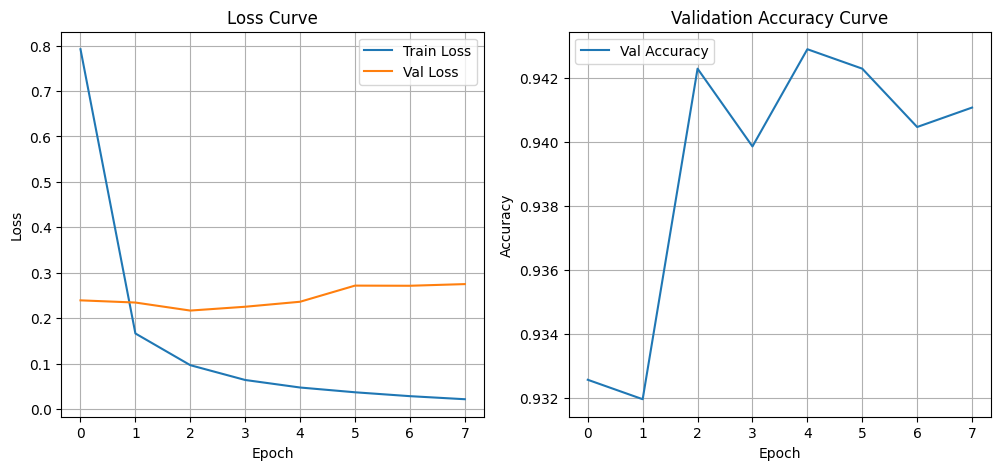

In [13]:
with torch.no_grad():
    preds = cnn(X_test_t).argmax(dim=1).cpu().numpy()

test_acc = accuracy_score(y_test, preds)
print("FINAL TEST ACCURACY:", test_acc * 100)


plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.show()
